# **Housing Prices Prediction Model**

### Predicting Housing prices in the state of california
* Download and Process the data
  * Download the data
  * Get an overview with the describe function
* Split the data into two subsets : Train and Test
* Discover and Visualise the Data to Gain Insights
  * Look for correlations and geographical data
  * Experiment with different attribute combinations 
* Prepare the data for the machine learning algorithms
  * Data cleaning
  * Feature Scaling
* Select and Train a suitable model
* Fine-tune the model
  * Grid Search
  * Randomised Search
  * Ensemble Methods
* Launch, Monitor & Maintain Your System
  * Deployment
  * Maintenance

In [1]:
import os
import tarfile
import urllib.request

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sklearn
assert sklearn.__version__ >= "0.20"

# **Create a Test and Train dataset**

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


fetch_housing_data()
housing = load_housing_data()
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


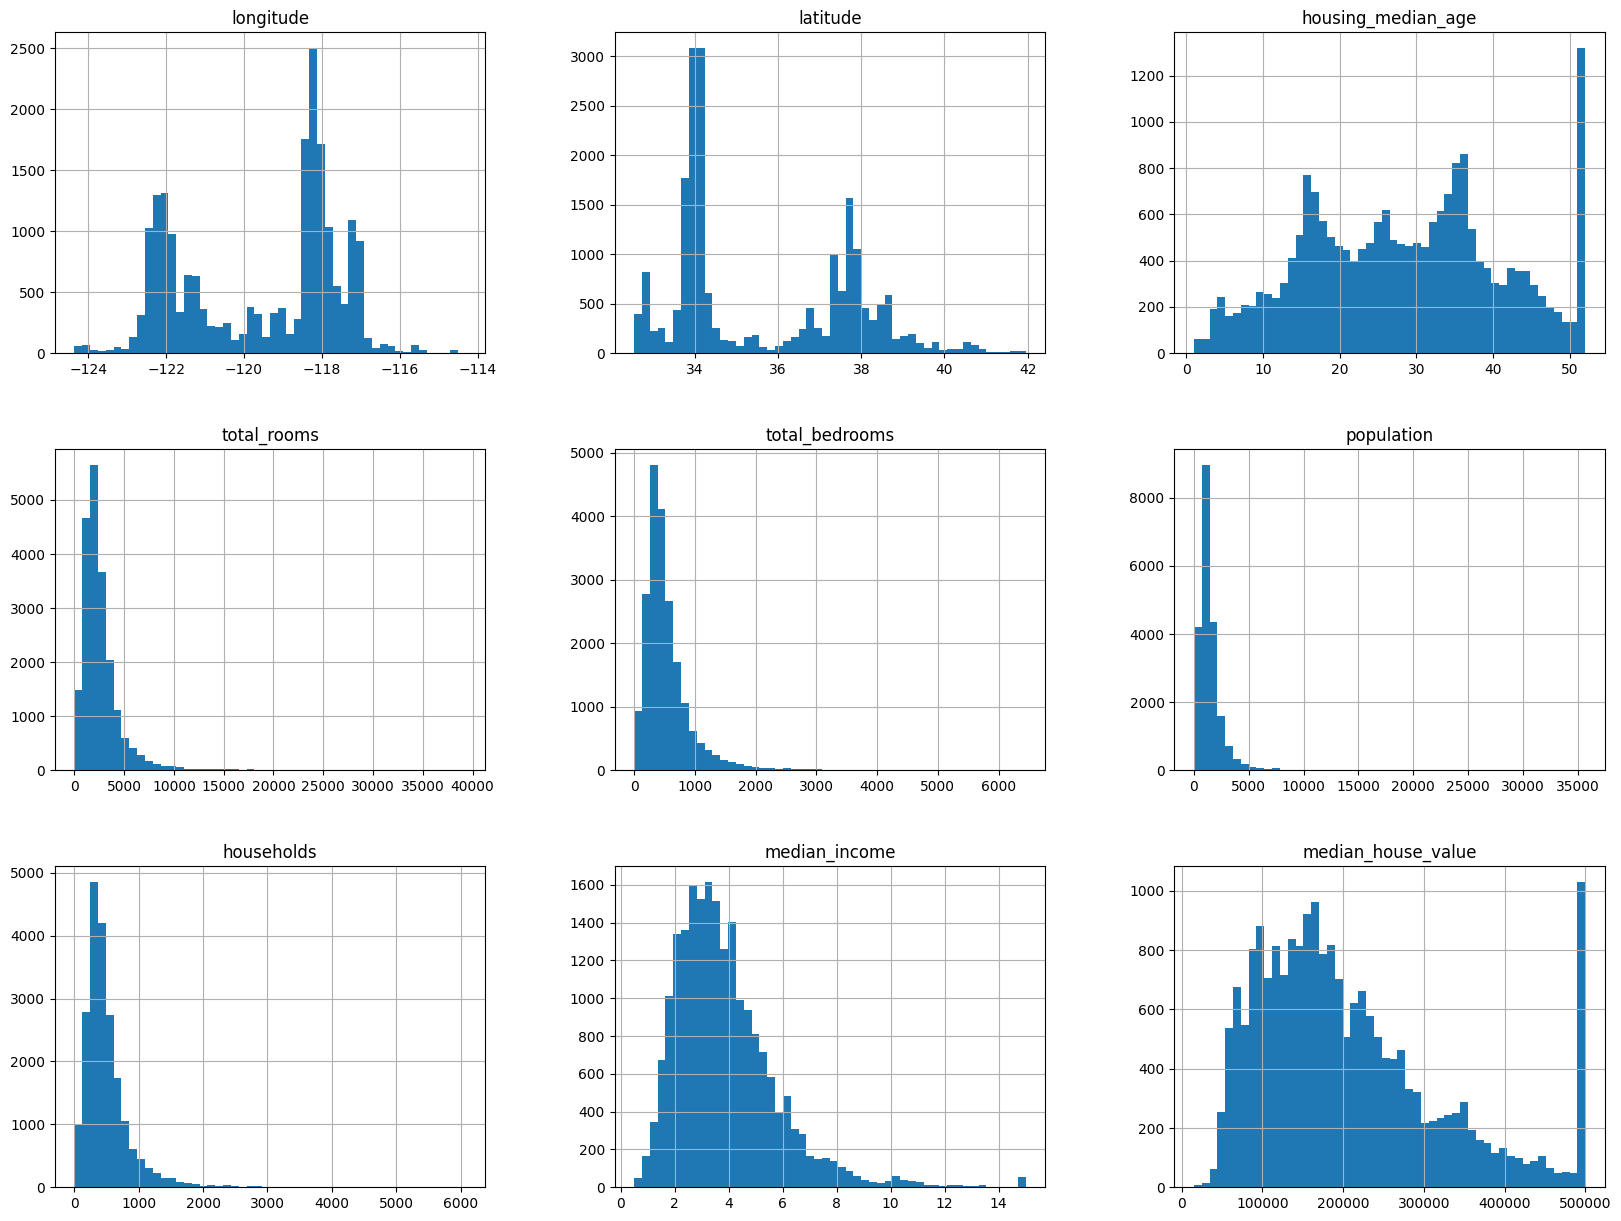

In [3]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [4]:
# Set a constant seed so that the train and test set are always identical on every run
from zlib import crc32


np.random.seed(42)

# For illustration only. Scikt-Learn has train_test_split()
def split_test_train(data, test_ratio): # take input of the data and the test_split ratio
          shuffled_indices = np.random.permutation(len(data)) # shuffle the data permutation based on the length of the data
          test_set_size = int(len(data) * test_ratio) # calculate the number of instances to include in test set
          test_indices = shuffled_indices[:test_set_size] # select the first portion of the data for test data
          train_indices = shuffled_indices[test_set_size:] # select the rest of portion for train data
          return data.iloc[train_indices], data.iloc[test_indices] # return the data in iloc form for access of rows by index

# We can also split the data into test and train by ID
# Also ensure that each instance has unqique and immutable identifier, so split remains stable even when dataset changes

def test_set_check(identifier, test_ratio):
          # convert identifier into 64-bit int, apply crc32 hash, compare against threshold
          return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# Function to split the dataset into train and test sets using stable ID-based hashing
def split_test_train_by_id(data, test_ratio, id_column):
          # Extract the identifier column from the dataset
          ids = data[id_column]
          
          # Apply the test_set_check to each identifier to decide if it's in the test test
          in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))

          # returns two datasets :
          # - Test set : rows where in_test_set is True
          # - Training set : rows where in_test_set is False
          return data.loc[~in_test_set], data.loc[in_test_set]

In [5]:
# Reset the index column, perform a train_test split and create a new more stable index ID column
# Perform train-test split again with the new 'id' based on geo-coordinates


# Reset the index of the DF so that new column can be named "index"
housing_with_id = housing.reset_index()

# Perform a train-test split using the 'index' column as the ID
# simple, quick solution for stable splits only if database wont change
train_set, test_set = split_test_train_by_id(housing_with_id, 0.2, "index")

# Create a new more stable ID based on lat and long coords
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

# Perform another train-test split using 'id' column based on geo-coordinates
# more robust solution that uses the data's inherent
train_set, test_set = split_test_train_by_id(housing_with_id, 0.2, "id")

# Quick overview of data
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

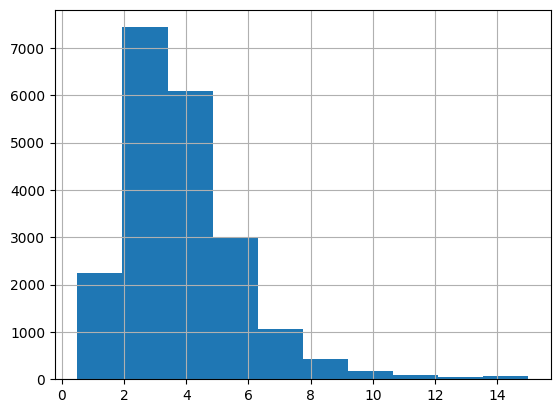

In [6]:
# Now using the Sklearn library for train-test split and Stratified Shuffle Split

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing["median_income"].hist()

# Create a new categorical column 'income_cat' by binning 'median_income' into discrete categories
# Binning is when the continuous variable is broken down into discrete groups or categories to help with analysis and enable stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"], # continuous variable to be binned
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf], # edges of the bins (intervals)
                              labels=[1, 2, 3, 4, 5]) # labels assigned to each bin to represent income categories

housing["income_cat"].value_counts()


<Axes: >

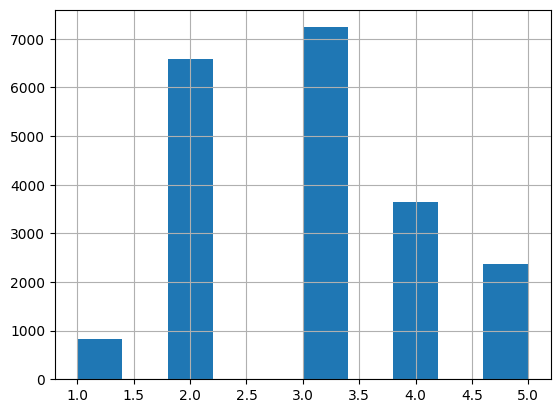

In [7]:
housing["income_cat"].hist()

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# Perform a stratified split on the housing data where only 20% of the data is used for the training
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Performs the split and maintains the income_cat distribution
for train_index, test_index in split.split(housing, housing["income_cat"]):
          strat_train_set = housing.loc[train_index] # Get training rows by index
          strat_test_set = housing.loc[test_index] # Get test rows by index

# Calculate the proportion of each income catgeory in the stratified test set
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

# Calculates the proportions of each income category in full dataset
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [9]:
# Helper function to calculate income category proportions for any dataset
def income_cat_proportions(data):
          return data["income_cat"].value_counts() / len(data)

# Perform a random train-test split without stratification
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)



compare_props = pd.DataFrame({
          "Overall": income_cat_proportions(housing),
          "Stratified": income_cat_proportions(strat_test_set),
          "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


In [ ]:
# Remove the stratification helper column to match the tutorial before preprocessing
for set_ in (strat_train_set, strat_test_set):
          set_.drop("income_cat", axis=1, inplace=True)


# **Discover and Visualise the Data to Gain Insights**

Saving figure geographical_visuals


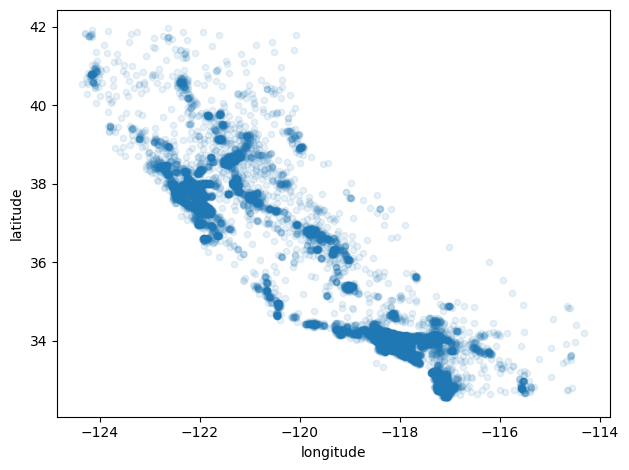

In [10]:
housing = strat_train_set.copy() # Make a copy of the data

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("geographical_visuals")

Saving figure housing_prices_scatterplot


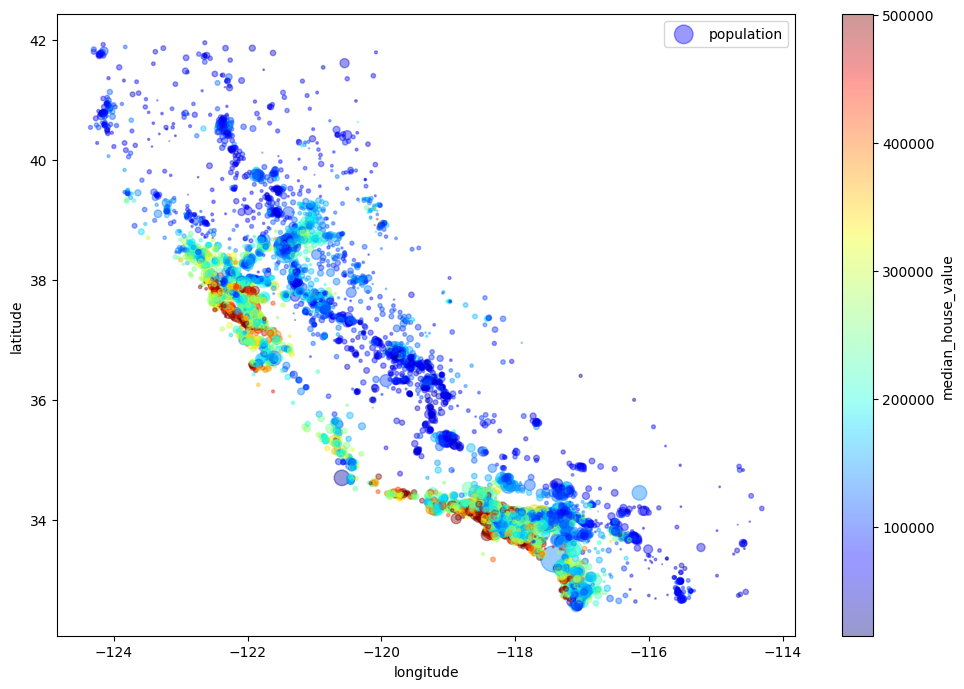

In [11]:
# New scatter plot with a density colour scale based on the population
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
# Plot housing prices by location, with color for value and size for population
plt.legend()

save_fig("housing_prices_scatterplot")

In [12]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x133cc3890>)

Saving figure california_housing_prices_plot


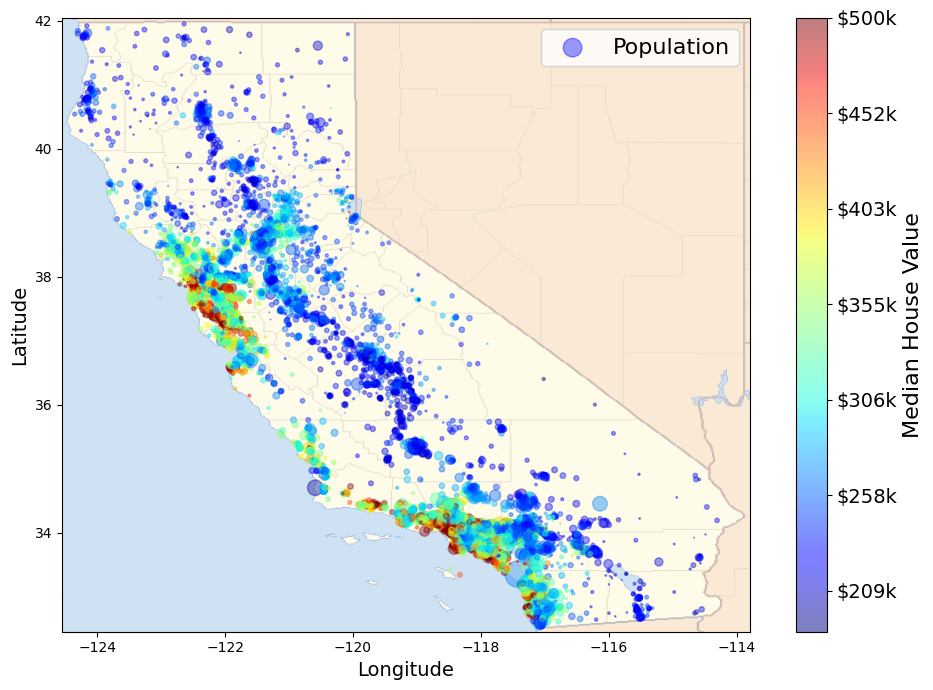

In [13]:
import matplotlib.image as mpimg

california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

## **Looking for Correlations**

- Since dataset is not too large sometimes, we can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attribute using the corr() method

- One last thing you may want to do before preparing the data for Machine Learning algorithms is to try out various attribute combinations
- After collecting the right pair of attribute combinations, you may again perform a correlation matrix to identify how well is the combination
- The point of choosing the right attributes is to start off at the right foot and quickly gain insights that will help you get a first reasonably good prototype
- This is an iterative process, once you get the prototype’s prediction, you can come back to this exploration step again

Saving figure scatter_matrix_plot


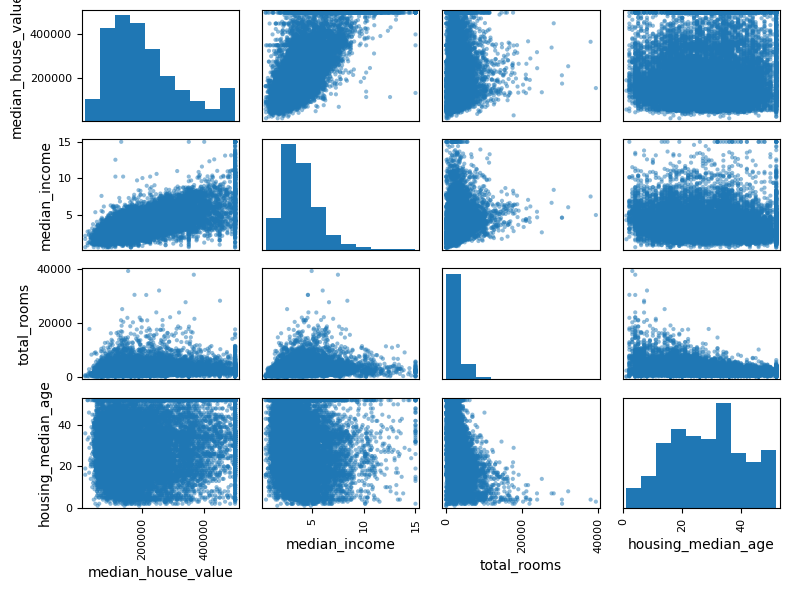

In [14]:
corr_matrix = housing.corr(numeric_only=True) # Correlation matrix

corr_matrix["median_house_value"].sort_values(ascending=False)

# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(8, 6))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


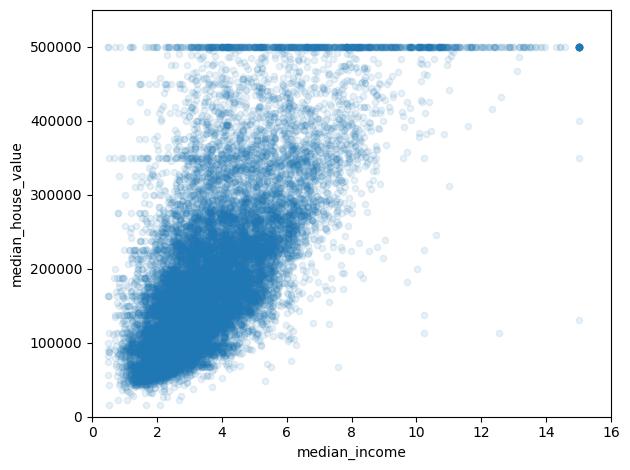

In [15]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

# The scatter plot shows a strong positive correlation — house values clearly rise with median income.  
# A visible price cap appears near $500,000, forming a horizontal boundary in the data.  
# Additional faint horizontal lines (around $450k, $350k, and $280k) suggest artificial value limits or rounding patterns.  
# It may be useful to remove these capped districts to avoid biasing the learning algorithm with such irregularities.

## **Experimenting with Attribute Combinations**

                          longitude  latitude  housing_median_age  \
longitude                  1.000000 -0.924478           -0.105823   
latitude                  -0.924478  1.000000            0.005737   
housing_median_age        -0.105823  0.005737            1.000000   
total_rooms                0.048909 -0.039245           -0.364535   
total_bedrooms             0.076686 -0.072550           -0.325101   
population                 0.108071 -0.115290           -0.298737   
households                 0.063146 -0.077765           -0.306473   
median_income             -0.019615 -0.075146           -0.111315   
median_house_value        -0.047466 -0.142673            0.114146   
rooms_per_household       -0.028374  0.107665           -0.147184   
bedrooms_per_room          0.095645 -0.116955            0.136768   
population_per_household  -0.000415  0.005426            0.015031   

                          total_rooms  total_bedrooms  population  households  \
longitude            

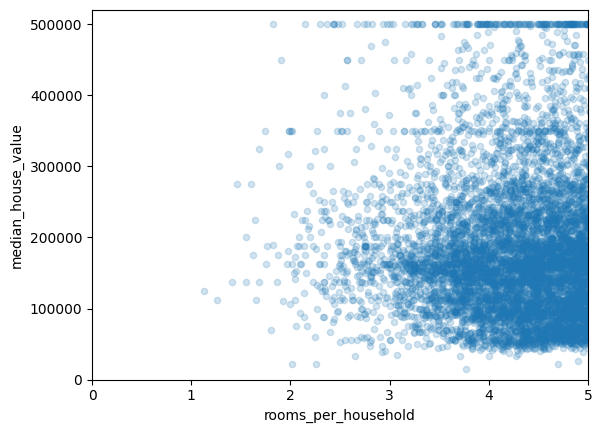

In [21]:
eda_df = strat_train_set.copy()

eda_df["rooms_per_household"] = eda_df["total_rooms"]/eda_df["households"]
eda_df["bedrooms_per_room"] = eda_df["total_bedrooms"]/eda_df["total_rooms"]
eda_df["population_per_household"] = eda_df["population"]/eda_df["households"]

corr_matrix = eda_df.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)
print(corr_matrix)

eda_df.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

## **Prepare the data for an ML Algorithm**

In [ ]:
housing_features = strat_train_set.drop("median_house_value", axis=1)  # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In the book 3 options are listed:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:

In [22]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY,2,4.707668,NaN,1.317891
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN,3,4.537074,NaN,3.947896
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN,3,5.826196,NaN,2.403023
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN,3,4.448980,NaN,2.840136
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN,5,6.835417,NaN,2.385417


In [23]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_18384/3907893688.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY,2,4.707668,NaN,1.317891
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN,3,4.537074,NaN,3.947896
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN,3,5.826196,NaN,2.403023
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN,3,4.448980,NaN,2.840136
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN,5,6.835417,NaN,2.385417


In [27]:
# Remove the text attribute because median can only be calculated on numerical attributes using the Imputer

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [35]:
housing_num = housing_features.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
imputer.statistics_

NameError: name 'housing_features' is not defined

In [33]:
housing_num.median().values

array([-1.18510000e+02,  3.42600000e+01,  2.90000000e+01,  2.11900000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54155000e+00,
        5.23234164e+00,  2.03027043e-01,  2.81766108e+00])